## Install Required Packages
Important to make sure that PyTorch is correctly installed! Handbook is provided in the Github

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths
os.chdir("/Users/yuanliu/Documents/Erasmus University/MSc Quantitive Marketing and Business Analytics/P3/Seminar Case Study/Data/case_studies_ah/")

In [2]:
%%capture 
pip install pyarrow

In [3]:
%%capture 
pip install fastparquet

In [4]:
%%capture
pip install ipywidget

## Import Libraries

In [5]:
import copy
from pathlib import Path
import warnings
import datetime

from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, EncoderNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display

from sklearn.metrics import mean_absolute_percentage_error

plt.style.use('ggplot')

colors = plt.cm.Spectral(np.linspace(0,1,30))
plt.rcParams["figure.figsize"] = (20,5)

# Set Seeds
seed = 2
np.random.seed(seed)
torch.manual_seed(seed);

## Import Data
This notebook works the same for all three commodities, first we define the commodity of interest. Choices:
- SUNFLOWER OIL
- MAIZE
- WHEAT

In [6]:
product_type = "WHEAT"
country_filter = "Germany" # 'Germany' 'Denmark' 'Spain' 'Belgium' are in the dataset
date_filter = datetime.date(year = 2018, month = 1, day = 1)
date_end = datetime.date(year = 2022, month = 10, day = 1)

In [7]:
if product_type == "WHEAT":
    trade_data = pd.read_csv("Data/wheat_similar_countries.csv")
    
if product_type == "MAIZE":
    trade_data = pd.read_csv("Data/maize_corn_similar_countries_new.csv")
    
if product_type == "SUNFLOWER OIL":
    trade_data = pd.read_csv("Data/sunflower_oil_similar_countries_new.csv")
    
# Add Time Period steps
trade_data["TIME_PERIOD"] = pd.to_datetime(trade_data["TIME_PERIOD"], format = '%Y-%m').dt.date
trade_data = trade_data.rename(columns={"partner": "PARTNER_codes", "declarant": "DECLARANT_codes"})

# Make sure that the right product is isolated
products = trade_data["product"].drop_duplicates().to_list()

if product_type == 'SUNFLOWER OIL' or product_type == 'MAIZE':
    product_filter = products[0]

if product_type == 'WHEAT':
    product_filter = products[0]
    
# Add correct labels to the partner and declarent indices
    
partner_countries = pd.read_csv("Data/partners.csv", sep = ";")
declarant_countries = pd.read_csv("Data/declarants.csv", sep = ";")
trade_data = pd.merge(trade_data, partner_countries, on = ['PARTNER_codes'], how = 'inner')
trade_data = pd.merge(trade_data, declarant_countries, on = ['DECLARANT_codes'], how = 'inner')

# Filter on correct declarant country
trade_data = trade_data[(trade_data["DECLARANT_Labels"] == country_filter)]

trade_data_pivot = trade_data.pivot(index=['PARTNER_Labels', 'TIME_PERIOD', 'product'], 
                              columns='indicators', 
                              values=['OBS_VALUE'])

trade_data_pivot.columns = trade_data_pivot.columns.map('_'.join)
trade_data_pivot = trade_data_pivot.reset_index()
trade_data_pivot = trade_data_pivot.dropna()

# Dataframe for total trade data per month which we are forecasting
trade_data_total = trade_data_pivot\
.groupby(['product', 'TIME_PERIOD']).agg({'OBS_VALUE_QUANTITY_TON': 'sum', 
                                          'OBS_VALUE_VALUE_1000EURO': 'sum'})

trade_data_total = trade_data_total.reset_index()
trade_data_total['price'] = trade_data_total['OBS_VALUE_VALUE_1000EURO']/trade_data_total['OBS_VALUE_QUANTITY_TON']
trade_data_total = trade_data_total[(trade_data_total["product"] == product_filter)]

trade_data_total = trade_data_total.set_index("TIME_PERIOD")
trade_data_total = trade_data_total[(trade_data_total.index >= date_filter)]

# Import other commodities and use same procedure
oil_data = pd.read_csv("Data/CMO-Historical-Data-Monthly.csv", header = 6)
oil_data = oil_data.rename(columns = {"Unnamed: 0" : "TIME_PERIOD"})
oil_data['TIME_PERIOD'] = oil_data['TIME_PERIOD'].str.replace(r'M', '-')
oil_data["TIME_PERIOD"] = pd.to_datetime(oil_data["TIME_PERIOD"], format = '%Y-%m').dt.date
to_replace = oil_data["SUNFLOWER_OIL"].iloc[0]
oil_data = oil_data.replace(to_replace, 0)
oil_data = oil_data.drop_duplicates()
oil_data = oil_data.set_index("TIME_PERIOD")
oil_data = oil_data[(oil_data.index >= date_filter) & (oil_data.index <= date_end)]

# Isolate Ukraine - Netherlands Import data for later use
Ukr_Data = trade_data_pivot[(trade_data_pivot['PARTNER_Labels']=='Ukraine') & (trade_data_pivot["product"] == product_filter) & (trade_data_pivot["TIME_PERIOD"] >= date_filter)][['TIME_PERIOD','OBS_VALUE_QUANTITY_TON']]
Ukr_Data = Ukr_Data.set_index("TIME_PERIOD")
Ukr_Data = Ukr_Data.rename(columns = {"OBS_VALUE_QUANTITY_TON" : "UKR_QUANTITY"})
trade_data_total['UKR_QUANTITY'] = Ukr_Data['UKR_QUANTITY']
trade_data_total = trade_data_total.fillna(0)

# Import NOAA weather data
weather_data = pd.read_csv("Data/global_temperature_data.csv")
weather_data = weather_data.rename(columns = {"yearmonth" : "TIME_PERIOD"})
weather_data["TIME_PERIOD"] = pd.to_datetime(weather_data["TIME_PERIOD"], format = '%Y%m').dt.date
weather_data = weather_data.set_index("TIME_PERIOD")
weather_data = weather_data[(weather_data.index >= date_filter) & (weather_data.index <= date_end)]

weather_ukr = weather_data[weather_data['weather_countryname'] == 'Ukraine']
weather_fr = weather_data[weather_data['weather_countryname'] == 'France']
weather_ger = weather_data[weather_data['weather_countryname'] == 'Germany']

# Merge data to one frame 
data = trade_data_total.merge(oil_data, on = 'TIME_PERIOD')
data = data[data.columns.drop(list(data.filter(regex='Unnamed')))]

data['avgTempUkr'] = weather_ukr["AVG_TAVG"] / 10
data['avgTempFr'] = weather_fr["AVG_TAVG"] / 10
data['avgTempGer'] = weather_ger["AVG_TAVG"] / 10


Add date variables

In [8]:
data['product'] = data['product'].astype(str)
data['timeidx'] = range(len(data))

data['year'] = pd.DatetimeIndex(data.index).year.astype(str).astype('category')
data['month'] = pd.DatetimeIndex(data.index).month.astype(str).astype('category')

test_split = datetime.date(year = 2021, month = 1, day = 1)
training_data = data[(data.index < test_split)]

# Add MA2 
data['NGAS_EUR_MA2'] = data["NGAS_EUR"].rolling(window=2).mean()
data['CRUDE_PETRO_MA2'] = data["CRUDE_PETRO"].rolling(window=2).mean()

In [9]:
data.tail()

,product,OBS_VALUE_QUANTITY_TON,OBS_VALUE_VALUE_1000EURO,price,UKR_QUANTITY,CRUDE_PETRO,CRUDE_BRENT,CRUDE_DUBAI,CRUDE_WTI,COAL_AUS,...,PLATINUM,SILVER,avgTempUkr,avgTempFr,avgTempGer,timeidx,year,month,NGAS_EUR_MA2,CRUDE_PETRO_MA2
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2022-06-01,100199,333258.5,119062.78,0.357269,510.2,116.80,120.08,115.73,114.59,374.08,...,956.59,21.56,20.945122,19.734634,18.873799,53,2022,6,31.365,113.450
2022-07-01,100199,225598.2,80964.05,0.358886,4387.7,105.08,108.92,106.48,99.85,402.20,...,869.25,19.08,21.286160,22.094888,19.872343,54,2022,7,42.445,110.940
2022-08-01,100199,325813.5,109725.92,0.336775,2520.4,95.97,98.60,97.75,91.57,406.97,...,908.65,19.72,22.452331,22.188199,20.880088,55,2022,8,60.685,100.525
2022-09-01,100199,338978.0,113393.67,0.334516,8270.9,88.22,90.16,90.63,83.87,430.81,...,881.24,18.94,13.617683,17.065057,13.996936,56,2022,9,64.570,92.095
2022-10-01,100199,432151.6,152650.60,0.353234,6573.5,90.33,93.13,90.59,87.26,389.79,...,914.67,19.43,11.385827,15.956502,13.011634,57,2022,10,49.060,89.275


## Set-up Model

Select the validation window (max_prediction_length) consisting of the number of final months of the war and the training window (max_encoder_length). max_prediction_length also controls the out-of-sample scenario forecasting length

In [12]:
max_prediction_length = 6
max_encoder_length = 12

# Set to len(data) - max_prediction_lenth if we want to assess in sample loss
training_cutoff = len(data) - max_prediction_length

# Make data copy
reduced_data_set = data.copy()
    
training = TimeSeriesDataSet(
    # SWITCHED FROM DATA
    reduced_data_set[lambda x: x.timeidx <= training_cutoff],
    time_idx="timeidx",
    target="price",
    group_ids=["product"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["product"],
    static_reals=[],
    time_varying_known_categoricals=["month"],
    time_varying_known_reals= [
        "timeidx", 
        "NGAS_EUR", 
        "CRUDE_PETRO", 
        "UKR_QUANTITY"
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "price",
        "OBS_VALUE_QUANTITY_TON",
        "OBS_VALUE_VALUE_1000EURO",
        "MAIZE",
        "WHEAT_US_HRW",
        "SUNFLOWER_OIL",
    ],
    target_normalizer=GroupNormalizer(
        # Earlier GroupNormalizer
        groups=["product"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series\
validation = TimeSeriesDataSet.from_dataset(training, reduced_data_set, predict=True, stop_randomization=True)

# SWITCHED FROM DATA
# validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


## Hyperparameter Tuning

Optuna Hyperparameter tuning study was used to find the best hyperparameter combination

In [13]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=10,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=60),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)
print(study.best_trial.value);

[I 2023-03-15 17:23:54,283] A new study created in memory with name: no-name-6bac402c-6058-4472-8017-d4f3254c69c2
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-03-15 17:24:01,676] Trial 0 finished with value: 0.0396118126809597 and parameters: {'gradient_clip_val': 0.5447266604677676, 'hidden_size': 111, 'dropout': 0.12580443905565267, 'hidden_continuous_size': 42, 'attention_head_size': 4, 'learning_rate': 0.03843727162012779}. Best is trial 0 with value: 0.0396118126809597.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-03-15 17:24:07,434] Trial 1 finished with value: 0.07027393579483032 and parameters: {'gradient_clip_val': 0.09199614830191527, 'hidden_size': 50, 'd

{'gradient_clip_val': 0.5447266604677676, 'hidden_size': 111, 'dropout': 0.12580443905565267, 'hidden_continuous_size': 42, 'attention_head_size': 4, 'learning_rate': 0.03843727162012779}
0.0396118126809597


## Save Best Results

In [14]:
res = study.best_trial.params


gradient_clip_val = res['gradient_clip_val']
hidden_size = res['hidden_size']
dropout = res['dropout']
hidden_continuous_size = res['hidden_continuous_size']
attention_head_size = res['attention_head_size']
learning_rate = res['learning_rate']

In [16]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger("lightning_logs") 

# Configure Trainer
trainer = pl.Trainer(
    max_epochs=400,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=gradient_clip_val,
    limit_train_batches=30,  
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

# Initialize the temporal fusion transformer
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=learning_rate,
    hidden_size=hidden_size,
    attention_head_size=attention_head_size,
    dropout=dropout,
    hidden_continuous_size=hidden_continuous_size,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  
    reduce_on_plateau_patience=4,
)

# Fit the model on the data
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

# Save the temporal fusion transformer and make predictions
best_tft = tft
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/lightning_logs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 73    
3  | prescalers                         | ModuleDict                      | 1.2 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 42.3 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 159 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 71.4 K
7  | static_context_variable_selection  |

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Plotter for In-Sample Validation

In [18]:
data_plotter = data.copy()
data_plotter["timeidx_mov"] = data_plotter["timeidx"] - (len(data_plotter) - max_prediction_length)
price_val = list(data_plotter['price'].tail(max_prediction_length))
    
y_pred = best_tft.to_quantiles(raw_predictions)
target =  torch.FloatTensor(price_val)

Quantile Loss =  0.030


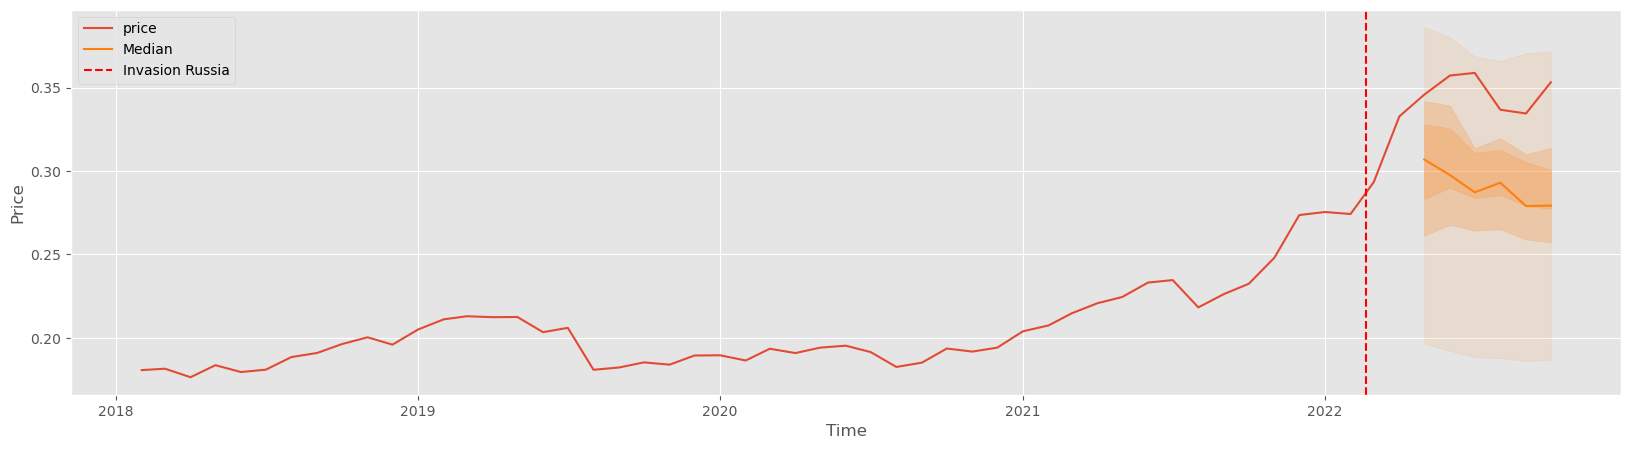

In [22]:
def forecaster_plotter(raw_dat, raw_predictions, data):
    q02, q10, q25, q5, q75, q90, q98 = [], [], [], [], [], [], []
    
    for i in range(len(raw_predictions[0])):
        q02.append(sorted(raw_predictions[0][i])[0].item())
        q10.append(sorted(raw_predictions[0][i])[1].item())
        q25.append(sorted(raw_predictions[0][i])[2].item())
        q5.append(sorted(raw_predictions[0][i])[3].item())
        q75.append(sorted(raw_predictions[0][i])[4].item())
        q90.append(sorted(raw_predictions[0][i])[5].item())
        q98.append(sorted(raw_predictions[0][i])[6].item())
                
    data_plotter = data.copy()
    data_plotter["timeidx_mov"] = data_plotter["timeidx"] - (len(data_plotter) - max_prediction_length)
    
    price_val = list(data_plotter['price'].tail(max_prediction_length))
    
    MAPE_price = mean_absolute_percentage_error(q5, price_val)
    y_pred = best_tft.to_quantiles(raw_dat)
    target =  torch.FloatTensor(price_val)
    
    print('Quantile Loss = ', "{:.3f}".format(torch.mean(QuantileLoss().loss(y_pred, target))))

    index_list = list(reduced_data_set.index.values)
    used_list = index_list[-max_prediction_length:]
    
    ax = data_plotter[(data_plotter.index > date_filter)][["price"]].plot()
    plt.fill_between(used_list, q02, q98, alpha = 0.1, color = 'tab:orange')
    plt.fill_between(used_list, q10, q90, alpha = 0.2, color = 'tab:orange')
    plt.fill_between(used_list, q25, q75, alpha = 0.2, color = 'tab:orange')

    plt.plot(used_list, q5, color = 'tab:orange', label = 'Median')
    plt.axvline(datetime.datetime(2022, 2, 20), color = 'red', linestyle = '--', label = 'Invasion Russia')

    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()

forecaster_plotter(raw_predictions, raw_predictions['prediction'], data)   

## Variables Importance and Attention

Below an eaxample of how one can extract the variable importance and attention scores

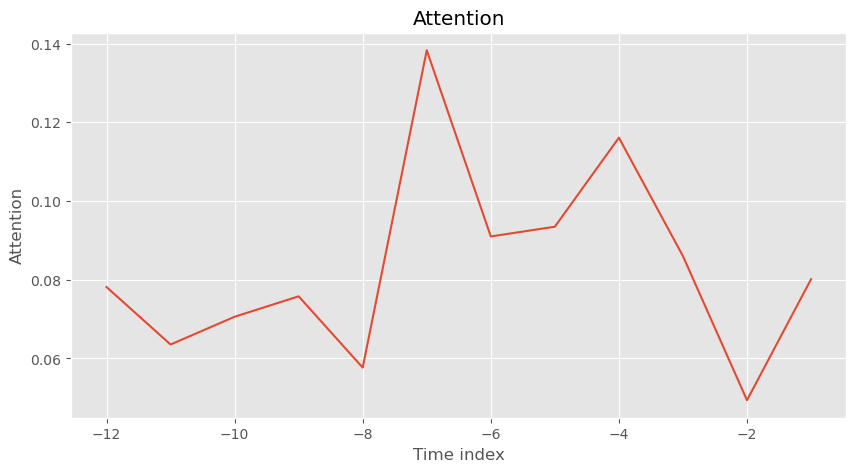

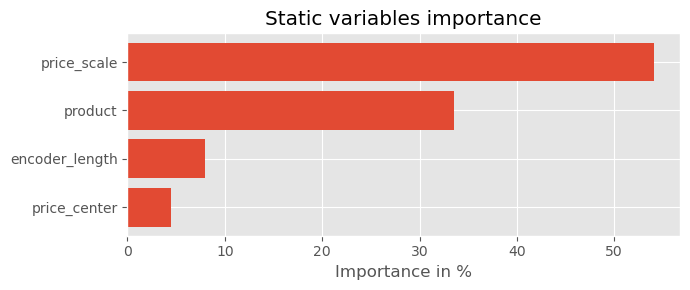

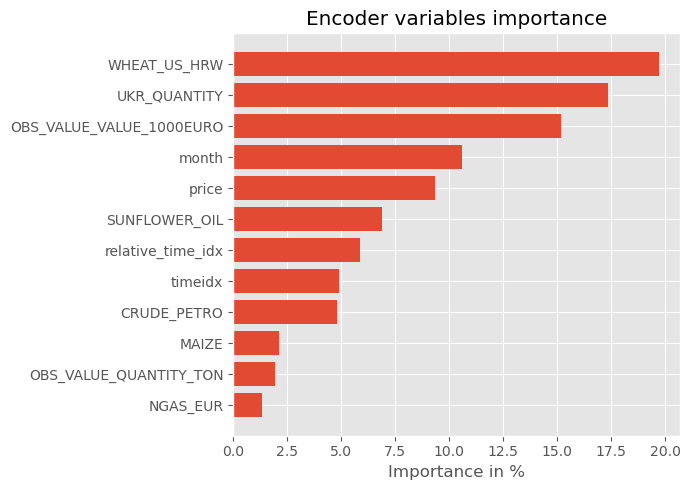

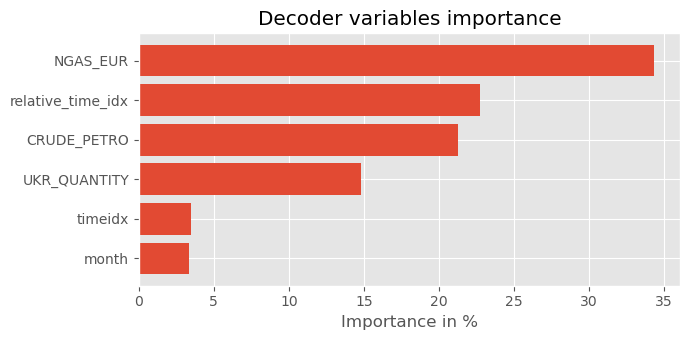

In [31]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation);